<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Simple_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
""" This demo program solves the Laplace equation with flux conditions"""
"""V.-D. Nguyen, J. Jansson, J. Hoffman, J.-R. Li, A partition of unity finite element method """
"""for computational diffusion MRI, J. Comput. Phys., August 2018."""
"""Section 7.1. Optimal convergence in space discretization"""


# Copyright (C) 2017 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of FEniCS
#
# FEniCS is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'Section 7.1. Optimal convergence in space discretization'

# Setting a working environment with FEniCS

In [3]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# Solve an interface problem

882  2.8284e-01   2.8284e-01   3.674528e-02


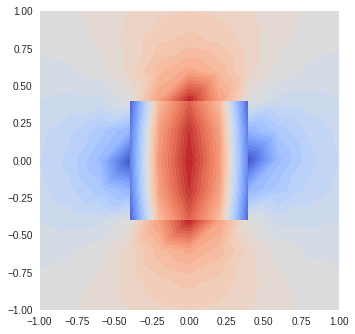

In [19]:
""" This demo program solves the Laplace equation with flux conditions"""

# Copyright (C) 2017 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of FEniCS
#
# FEniCS is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.



XMIN, XMAX, YMIN, YMAX = -1.0, 1.0, -1.0, 1.0
porder = 2;

case = "square"
if case=="square":
    eps = 1e-4;
    nx, ny = 10, 10;
    factor = 1;
    mesh = RectangleMesh(Point(XMIN, YMIN), Point(XMAX, YMAX), factor*nx, factor*ny, "right")
else:
    print(case)
    factor = 1;
    SEGMENTS = 10*factor;
    mre = 10*factor;
    R = 0.5;
    domain = Rectangle(Point(XMIN, YMIN), Point(XMAX, YMAX))
    circle = Circle(Point(0, 0), R, SEGMENTS)
    domain.set_subdomain(1, circle)
    mesh = generate_mesh(domain, mre)
 
# plot(mesh)

hmin = mesh.hmin();
h = Circumradius(mesh);
# h = 0.5*CellSize(mesh);

###
def ieval(u,omega):
    if omega==2:
        return u('+')*theta('+') + u('-')*theta('-') + u('+')*(1.-theta('+')) + u('-')*(1.-theta('-'));
    if omega==1:
        return u('+')*theta('+') + u('-')*theta('-');
    if omega==0:
        return u('+')*(1.-theta('+')) + u('-')*(1.-theta('-'))

def NodeNormal(mesh, theta):
    V = VectorFunctionSpace(mesh , "CG", 1);
    u = TrialFunction(V)
    v = TestFunction(V)
    n = FacetNormal(mesh);
    lamb = 1000./h;
    a=inner(u,v)*dx + lamb*inner(u,v)*ds + avg(lamb)*inner(ieval(u,0),ieval(v,0))*abs(jump(theta))*dS
    L=lamb*inner(n,v)*ds + avg(lamb)*inner(ieval(n,0),ieval(v,0))*abs(jump(theta))*dS
    w = Function(V)
    solve(a==L, w);
    
    class MyExpression0(Expression):
        def eval(self, value, x):
            xx = w(x)
            norm = pow(xx[0]*xx[0]+xx[1]*xx[1],0.5)
            if norm<0.8:
                value[0] = 0;
                value[1] = 0
            else:
                value[0] = xx[0]/norm;
                value[1] = xx[1]/norm;
        def value_shape(self):
            return (2,)
    f0 = MyExpression0(degree=8)
    
    w = interpolate(f0,V);
    return w;
####

class Exterior(SubDomain):
    def inside (self,x,on_boundary):
        if case=="square":
            return x[0]*x[0]>0.4*0.4-hmin/10. or x[1]*x[1]>0.4*0.4-hmin/10.
        else:
            d = sqrt((x[0])*(x[0])+(x[1])*(x[1]));
            return d>=R-hmin/4.0;

class DirichletBoundary(SubDomain):
    def inside (self,x,on_boundary):
        return on_boundary;

# Mark exterior domain to 1, interior domain to 0
exterior = Exterior();

# cellmarker = CellFunction("size_t", mesh)
cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())
cellmarker.set_all(0)
exterior.mark(cellmarker,1)

V_DG = FunctionSpace(mesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
theta = Function(V_DG)
theta0 = Function(V_DG)

for cell in cells(mesh):
  theta.vector()[dofmap_DG.cell_dofs(cell.index())] = cellmarker[cell.index()];
  theta0.vector()[dofmap_DG.cell_dofs(cell.index())] = 1.0-cellmarker[cell.index()];


# plot(theta);

W = VectorFunctionSpace(mesh , "CG", porder);

mesh0 = SubMesh(mesh, cellmarker, 0)
mesh1 = SubMesh(mesh, cellmarker, 1)

def SubMeshSol(u, mesh, dolfin_version):
    if dolfin_version=='1.6.0':
        V = FunctionSpace(mesh, "CG", porder)
    else:
        # For FEniCS 2016, 2017
        Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
        V = FunctionSpace(mesh, Ve)
    u_p = project(u, V);
    return u_p;

# plot(theta); interactive(); stop;

# uexact1 = Expression("x[0]*x[0]*x[0]*x[0]+x[1]*x[1]*x[1]*x[1]+10", domain=mesh, degree=8);
uexact1=Expression ("(pow(pow(x[0],2) + pow(x[1],2),2) - pow(x[0],2) + pow(x[1],2))/pow(pow(x[0],2) + pow(x[1],2)+1e-10,2)",domain=mesh, degree=8);

#uexact0 = Expression("-x[0]*x[0]-x[1]*x[1]", domain=mesh, degree=8);
uexact0 = Expression("16.*(0.5 - pow(x[0],2))*(4.0 - pow(x[1],2))-20.0", domain=mesh, degree=8);

f1 = uexact1
# f1 =Expression("-12*(pow(x[0],2)+pow(x[1],2))", degree=8)+uexact1

# f0 =Expression("4.0", degree=8)+uexact0
f0 =Expression("- 32*pow(x[0],2) - 32*pow(x[1],2) + 144",domain=mesh, degree=8)+uexact0

u = TrialFunction(W);

v = TestFunction(W);

a = ( inner(grad(u[0]),grad(v[0]))+u[0]*v[0] )*theta0*dx + ( inner(grad(u[1]),grad(v[1]))+u[1]*v[1] )*theta*dx

n = FacetNormal(mesh);
n = ieval(n,0);

L = f0*v[0]*(1-theta)*dx + f1*v[1]*theta*dx;

gradu0 = grad(uexact0)
gradu1 = grad(uexact1)

jum_g = inner(ieval(gradu0,0)-ieval(gradu1,0),n);
avg_g = 0.5*inner(ieval(gradu0,0)+ieval(gradu1,0),n);

L += ( jum_g*0.5*(ieval(v[0],0)+ieval(v[1],1)) + avg_g*(ieval(v[0],0)-ieval(v[1],1)) )*abs(jump(theta))*dS

dbc = DirichletBoundary();
bc0 = DirichletBC(W.sub(0), uexact0, dbc)
bc1 = DirichletBC(W.sub(1), uexact1, dbc)
bcs = [bc0, bc1];

A,b=assemble_system(a,L)

for bc in bcs:
    bc.apply(A);
    bc.apply(b);


A.ident_zeros();

U = Function(W)

solver = KrylovSolver("cg","none")
solver.parameters["relative_tolerance"] = 1e-7
solver.parameters["maximum_iterations"] = 5000

solve(A, U.vector(), b)

(U0, U1) = U.split(True)

file_u0 = File("U0.pvd")
file_u1 = File("U1.pvd")


U0_p=SubMeshSol(U0, mesh0, dolfin_version)
U1_p=SubMeshSol(U1, mesh1, dolfin_version)

file_u0 << U0_p;
file_u0 << U1_p;

error_u0 = (U0-uexact0)*(U0-uexact0)*(1-theta)
error_u1 = (U1-uexact1)*(U1-uexact1)*theta;
L2u_err0= assemble((error_u0)*dx)
L2u_err1= assemble((error_u1)*dx)

plot(U0_p, cmap="coolwarm")
plot(U1_p, cmap="coolwarm")

print("%d"%U.vector().size()," %.4e "%mesh.hmin(), " %.4e "%mesh.hmax()," %e"%sqrt(L2u_err0+L2u_err1))